In [ ]:
!pip install transformers requests pillow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

# dataset path
dataset_path = '/content/drive/MyDrive/fake-news-detection/Dataset/'

# Load the TSV files
train_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_train.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_validate.tsv'), sep='\t')
test_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_test_public.tsv'), sep='\t')

print("Training set shape:", train_df.shape)
print("\nValidation set shape:", validate_df.shape)
print("\nTest set shape:", test_df.shape)

Training set shape: (564000, 16)

Validation set shape: (59342, 16)

Test set shape: (59319, 16)


In [3]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 1. Configuration
TARGET_TRAIN_SIZE = 10000
TARGET_VAL_SIZE = 2000

def check_url(row):
    """
    Returns the row if the URL is valid (Status 200), otherwise None.
    """
    url = row['image_url']
    try:
        response = requests.head(url, timeout=3, allow_redirects=True)
        if response.status_code == 200:
            return row
    except:
        return None
    return None

def get_clean_samples(df, target_size):
    """
    Iterates through the dataframe until it finds 'target_size' valid images.
    """
    clean_rows = []

    # We shuffle first to get a random distribution
    shuffled_df = df.sample(frac=1, random_state=42)

    print(f"Scanning for {target_size} valid images...")

    with ThreadPoolExecutor(max_workers=20) as executor:

        futures = []
        for i in range(len(shuffled_df)):
            futures.append(executor.submit(check_url, shuffled_df.iloc[i]))
            if len(futures) >= target_size * 2:
                break

        for future in tqdm(futures, total=len(futures)):
            result = future.result()
            if result is not None:
                clean_rows.append(result)
                if len(clean_rows) >= target_size:
                    break

    return pd.DataFrame(clean_rows)

print("Cleaning Training Set...")
df_train_clean = get_clean_samples(train_df, TARGET_TRAIN_SIZE)
print(f"Secured {len(df_train_clean)} valid training images.")

print("Cleaning Validation Set...")
df_val_clean = get_clean_samples(validate_df, TARGET_VAL_SIZE)
print(f"Secured {len(df_val_clean)} valid validation images.")

print("Cleaning Test Set...")
df_test_clean = get_clean_samples(test_df, TARGET_VAL_SIZE)
print(f"Secured {len(df_test_clean)} valid test images.")

Cleaning Training Set...
Scanning for 10000 valid images...


100%|██████████| 20000/20000 [01:30<00:00, 220.43it/s]


Secured 6765 valid training images.
Cleaning Validation Set...
Scanning for 2000 valid images...


100%|██████████| 4000/4000 [00:17<00:00, 230.29it/s]


Secured 1134 valid validation images.
Cleaning Test Set...
Scanning for 2000 valid images...


100%|██████████| 4000/4000 [00:14<00:00, 277.96it/s]

Secured 1087 valid test images.


In [4]:
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

class MultimodalCLIPClassifier(nn.Module):
    def __init__(self, num_labels=6):
        super(MultimodalCLIPClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        for param in self.clip.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(1280, num_labels)

    def forward(self, input_ids, pixel_values, attention_mask):
        outputs = self.clip(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask
        )

        text_features = outputs.text_model_output.pooler_output
        image_features = outputs.vision_model_output.pooler_output

        combined_features = torch.cat((image_features, text_features), dim=1)

        logits = self.classifier(combined_features)

        return logits

In [5]:
import requests
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset

class FakedditMultimodalDataset(Dataset):
    def __init__(self, df, processor):
        self.data = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        text = str(self.data.iloc[idx]['clean_title'])
        label = self.data.iloc[idx]['6_way_label']
        img_url = self.data.iloc[idx]['image_url']

        try:
            response = requests.get(img_url, timeout=5)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        except:

            image = Image.new('RGB', (224, 224), color='black')

        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [10]:
from torch.utils.data import DataLoader
from transformers import CLIPProcessor
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

train_dataset = FakedditMultimodalDataset(df_train_clean, processor)
val_dataset = FakedditMultimodalDataset(df_val_clean, processor)
test_dataset = FakedditMultimodalDataset(df_test_clean, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = MultimodalCLIPClassifier(num_labels=6).to(device)

optimizer = optim.Adam(model.classifier.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()



In [11]:
from tqdm import tqdm

def train_multimodal_epoch(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    correct = 0

    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, pixel_values, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


In [12]:
def eval_multimodal_epoch(model, criterion, loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, pixel_values, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            correct += (logits.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

In [13]:

epochs = 5
best_val_acc = 0

print("Starting Training...")

for epoch in range(epochs):
    print(f"\n=== Epoch {epoch + 1}/{epochs} ===")

    # 1. Train
    train_loss, train_acc = train_multimodal_epoch(model, optimizer, criterion, train_loader)

    # 2. Validate
    val_loss, val_acc = eval_multimodal_epoch(model, criterion, val_loader)

    # 3. Report
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # 4. Save Checkpoint (if improved)
    if val_acc > best_val_acc:
        print(f"--> Accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...")
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_multimodal_clip.pt')

Starting Training...

=== Epoch 1/5 ===


Validation: 100%|██████████| 142/142 [01:01<00:00,  2.29it/s]


Train Loss: 0.6932 | Train Acc: 0.7484
Val Loss:   0.4915 | Val Acc:   0.8192
--> Accuracy improved from 0.0000 to 0.8192. Saving model...

=== Epoch 2/5 ===


Validation: 100%|██████████| 142/142 [01:01<00:00,  2.31it/s]


Train Loss: 0.4513 | Train Acc: 0.8389
Val Loss:   0.4406 | Val Acc:   0.8342
--> Accuracy improved from 0.8192 to 0.8342. Saving model...

=== Epoch 3/5 ===


Validation: 100%|██████████| 142/142 [01:00<00:00,  2.35it/s]


Train Loss: 0.3878 | Train Acc: 0.8594
Val Loss:   0.4135 | Val Acc:   0.8413
--> Accuracy improved from 0.8342 to 0.8413. Saving model...

=== Epoch 4/5 ===


Validation: 100%|██████████| 142/142 [01:02<00:00,  2.28it/s]


Train Loss: 0.3470 | Train Acc: 0.8715
Val Loss:   0.4017 | Val Acc:   0.8439
--> Accuracy improved from 0.8413 to 0.8439. Saving model...

=== Epoch 5/5 ===


Validation: 100%|██████████| 142/142 [01:03<00:00,  2.25it/s]


Train Loss: 0.3180 | Train Acc: 0.8865
Val Loss:   0.4006 | Val Acc:   0.8510
--> Accuracy improved from 0.8439 to 0.8510. Saving model...


In [14]:
best_model = MultimodalCLIPClassifier().to(device)
best_model.load_state_dict(torch.load('best_multimodal_clip.pt'))

test_loss, test_acc = eval_multimodal_epoch(best_model, criterion, test_loader)

print("="*30)
print(f"FINAL TEST RESULTS")
print("="*30)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")
print("="*30)

Validation: 100%|██████████| 136/136 [00:59<00:00,  2.30it/s]

FINAL TEST RESULTS
Test Accuracy: 0.8464
Test Loss:     0.3884


Generating predictions...
Total batches to process: 142


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


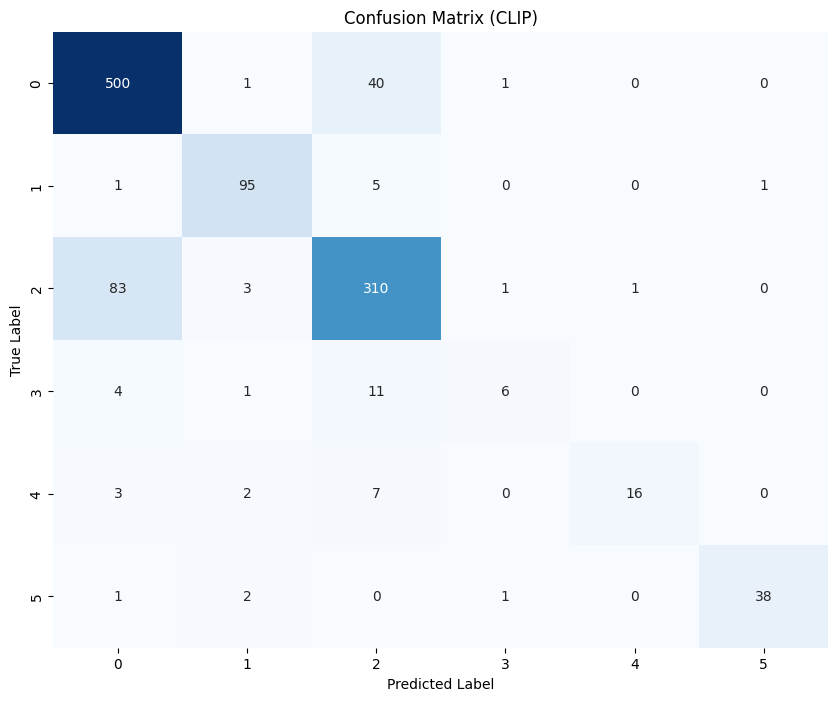

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_all_preds_clip(model, loader):
    all_preds = []
    all_labels = []
    model.eval()

    print(f"Total batches to process: {len(loader)}")

    with torch.no_grad():
        for batch in loader:

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)

            labels = batch.get('label', batch.get('labels')).to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values
            )

            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            _, preds = torch.max(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


print("Generating predictions...")
preds, labels = get_all_preds_clip(model, val_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (CLIP)')
plt.show()

In [22]:
from sklearn.metrics import classification_report

class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

print("-----------------------------------------------------------")
print("                CLASSIFICATION REPORT")
print("-----------------------------------------------------------")

report = classification_report(labels, preds, target_names=class_names, digits=4)
print(report)

-----------------------------------------------------------
                CLASSIFICATION REPORT
-----------------------------------------------------------
              precision    recall  f1-score   support

     Class 0     0.8446    0.9225    0.8818       542
     Class 1     0.9135    0.9314    0.9223       102
     Class 2     0.8311    0.7789    0.8042       398
     Class 3     0.6667    0.2727    0.3871        22
     Class 4     0.9412    0.5714    0.7111        28
     Class 5     0.9744    0.9048    0.9383        42

    accuracy                         0.8510      1134
   macro avg     0.8619    0.7303    0.7741      1134
weighted avg     0.8498    0.8510    0.8465      1134

